In [5]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai langchain_community tavily-python graphviz


In [9]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

llm.invoke("greet me")


AIMessage(content='Hello there!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-18155d86-3f7f-4f27-8e8b-9e622ec31f15-0', usage_metadata={'input_tokens': 3, 'output_tokens': 4, 'total_tokens': 7, 'input_token_details': {'cache_read': 0}})

In [ ]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# New: Function to delete a record by ID
def delete_from_db(conversation_id):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("DELETE FROM chat_history WHERE id = ?", (conversation_id,))
    conn.commit()
    conn.close()

# New: Function to update a record by ID
def update_record(conversation_id, new_user_input=None, new_bot_response=None):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    if new_user_input:
        cursor.execute("UPDATE chat_history SET user_input = ? WHERE id = ?", (new_user_input, conversation_id))
    if new_bot_response:
        cursor.execute("UPDATE chat_history SET bot_response = ? WHERE id = ?", (new_bot_response, conversation_id))
    conn.commit()
    conn.close()

# New: Function to fetch all records
def fetch_all_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)


# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Implement the chatbot function
def chatbot():
    print("Welcome to the Chatbot! Type 'exit', 'quit', 'q' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")
    print("Type 'delete <id>' to delete a conversation by ID.\n")
    print("Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break
        elif user_input.lower() in ["data", "history", "h"]:
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        elif user_input.lower().startswith("delete"):
            try:
                conversation_id = int(user_input.split()[1])
                delete_from_db(conversation_id)
                print(f"Deleted conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'delete <id>'.")
        elif user_input.lower().startswith("update"):
            try:
                parts = user_input.split(maxsplit=3)
                conversation_id = int(parts[1])
                new_user_input = parts[2]
                new_bot_response = parts[3]
                update_record(conversation_id, new_user_input, new_bot_response)
                print(f"Updated conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'update <id> <new_user_input> <new_bot_response>'.")
        else:
            response = agent.run(user_input)
            print(f"Bot: {response}")
            save_to_db(user_input, response)

# Step 8: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


Welcome to the Chatbot! Type 'exit', 'quit', 'q' to end the conversation.

Type 'history' to view the last 10 conversations.

Type 'delete <id>' to delete a conversation by ID.

Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.

You: hi


> Entering new AgentExecutor chain...
Thought: The question "hi" is a greeting and doesn't require any specific action or research.  A simple response is sufficient.

Final Answer: Hi there!


> Finished chain.
Bot: Hi there!
You: q
Goodbye!


In [11]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
import os

# Step 1: Set up API keys
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"


# Step 2: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# New: Function to delete conversation by ID
def delete_from_db(conversation_id):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()

    # First, check if the conversation exists
    cursor.execute("SELECT * FROM chat_history WHERE id = ?", (conversation_id,))
    row = cursor.fetchone()
    if row:
        # Proceed with deletion if found
        cursor.execute("DELETE FROM chat_history WHERE id = ?", (conversation_id,))
        conn.commit()
        print(f"Conversation with ID {conversation_id} has been deleted.")
    else:
        print(f"No conversation found with ID {conversation_id}.")

    conn.close()


# Step 3: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 4: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 5: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

# Step 6: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 7: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)
# Step 8: Implement the chatbot function with delete feature
def chatbot():
    print("Welcome to the Chatbot! Type 'quit', 'exit', 'q' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")
    print("Type 'delete <id>' to delete a conversation by ID.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        elif user_input.lower() in ["history", "data", "h"]:
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        elif user_input.lower().startswith("delete"):
            try:
                # Extract conversation ID to delete
                parts = user_input.split()
                if len(parts) > 1:
                    conversation_id = int(parts[1])
                    delete_from_db(conversation_id)  # Delete the conversation
                else:
                    print("Please provide a conversation ID to delete.")
            except ValueError:
                print("Invalid conversation ID. Please provide a numeric ID.")
        else:
            response = agent.run(user_input)
            print(f"Bot: {response}")

            # Save to SQLite database
            save_to_db(user_input, response)

# Step 9: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()




<ipython-input-11-30220f2935a9>:72: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
<ipython-input-11-30220f2935a9>:93: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. See LangGraph documentation for more details: https://langchain-ai.github.io/langgraph/. Refer here for its pre-built ReAct agent: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/
  agent = initialize_agent(


Welcome to the Chatbot! Type 'quit', 'exit', 'q' to end the conversation.

Type 'history' to view the last 10 conversations.

Type 'delete <id>' to delete a conversation by ID.

You: q
Goodbye!


In [ ]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.memory import ConversationBufferMemory


# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM


# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Implement the chatbot function
def chatbot():
    print("Welcome to the Chatbot! Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            response = agent.run(user_input)
            print(f"Bot: {response}")
            save_to_db(user_input, response)

# Step 8: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


Welcome to the Chatbot! Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

You: q
Goodbye!


In [ ]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# New: Function to delete a record by ID
def delete_from_db(conversation_id):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("DELETE FROM chat_history WHERE id = ?", (conversation_id,))
    conn.commit()
    conn.close()

# New: Function to update a record by ID
def update_record(conversation_id, new_user_input=None, new_bot_response=None):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    if new_user_input:
        cursor.execute("UPDATE chat_history SET user_input = ? WHERE id = ?", (new_user_input, conversation_id))
    if new_bot_response:
        cursor.execute("UPDATE chat_history SET bot_response = ? WHERE id = ?", (new_bot_response, conversation_id))
    conn.commit()
    conn.close()

# New: Function to fetch all records
def fetch_all_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = OpenAI(model="gpt-3.5-turbo", temperature=0.7, max_tokens=200)

# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Implement the chatbot function
def chatbot():
    print("Welcome to the Chatbot! Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")
    print("Type 'delete <id>' to delete a conversation by ID.\n")
    print("Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() == "exit":
            print("Goodbye!")
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        elif user_input.lower().startswith("delete"):
            try:
                conversation_id = int(user_input.split()[1])
                delete_from_db(conversation_id)
                print(f"Deleted conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'delete <id>'.")
        elif user_input.lower().startswith("update"):
            try:
                parts = user_input.split(maxsplit=3)
                conversation_id = int(parts[1])
                new_user_input = parts[2]
                new_bot_response = parts[3]
                update_record(conversation_id, new_user_input, new_bot_response)
                print(f"Updated conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'update <id> <new_user_input> <new_bot_response>'.")
        else:
            response = agent.run(user_input)
            print(f"Bot: {response}")
            save_to_db(user_input, response)

# Step 8: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


ValidationError: 1 validation error for OpenAI
  Value error, Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass `openai_api_key` as a named parameter. [type=value_error, input_value={'temperature': 0.7, 'max...ne, 'http_client': None}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

In [ ]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = OpenAI(model="gpt-3.5-turbo", temperature=0.7, max_tokens=200)

# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Define medical keywords and filtering function
MEDICAL_KEYWORDS = [
    "medicine", "symptoms", "diagnosis", "treatment", "disease", "doctor",
    "hospital", "health", "surgery", "therapy", "infection", "pharmacy", "drug"
]

def is_medical_prompt(prompt):
    """Check if the prompt contains medical-related keywords."""
    return any(keyword.lower() in prompt.lower() for keyword in MEDICAL_KEYWORDS)

# Step 8: Implement the chatbot function
def chatbot():
    print("Welcome to the Medical Chatbot! I only answer medical-related questions.\n")
    print("Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            if is_medical_prompt(user_input):
                response = agent.run(user_input)
                print(f"Bot: {response}")
                save_to_db(user_input, response)
            else:
                print("I'm sorry, I can only assist with medical-related questions.")

# Step 9: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


In [17]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
from graphviz import Digraph

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Define medical keywords and filtering function
MEDICAL_KEYWORDS = [
    "medicine", "symptoms", "diagnosis", "treatment", "disease", "doctor",
    "hospital", "health", "surgery", "therapy", "infection", "pharmacy", "drug"
]

def is_medical_prompt(prompt):
    """Check if the prompt contains medical-related keywords."""
    return any(keyword.lower() in prompt.lower() for keyword in MEDICAL_KEYWORDS)

# Step 8: Initialize workflow visualization
workflow_graph = Digraph("Chatbot Workflow", format="png")
workflow_graph.attr(rankdir="LR")  # Set direction of flow
workflow_graph.node("Start", shape="ellipse", style="filled", color="lightblue")
workflow_graph.node("Filter Prompt", shape="box", style="filled", color="lightgreen")
workflow_graph.node("Generate Response", shape="box", style="filled", color="lightyellow")
workflow_graph.node("Save to DB", shape="box", style="filled", color="orange")
workflow_graph.node("End", shape="ellipse", style="filled", color="lightblue")
workflow_graph.edges([("Start", "Filter Prompt"), ("Filter Prompt", "Generate Response"),
                      ("Generate Response", "Save to DB"), ("Save to DB", "End")])

def render_workflow():
    """Render and display the workflow graph."""
    workflow_graph.render("chatbot_workflow", view=True)

# Step 9: Implement the chatbot function
def chatbot():
    print("Welcome to the Medical Chatbot! I only answer medical-related questions.\n")
    print("Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            render_workflow()  # Display workflow graph at the end
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            workflow_graph.node(user_input, shape="ellipse", style="dashed", color="grey")
            workflow_graph.edge("Start", user_input)

            if is_medical_prompt(user_input):
                workflow_graph.edge(user_input, "Filter Prompt")
                response = agent.run(user_input)
                workflow_graph.edge("Filter Prompt", "Generate Response")
                print(f"Bot: {response}")
                save_to_db(user_input, response)
                workflow_graph.edge("Generate Response", "Save to DB")
            else:
                print("I'm sorry, I can only assist with medical-related questions.")
                workflow_graph.edge(user_input, "Filter Prompt")
                workflow_graph.edge("Filter Prompt", "End")

# Step 10: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


Welcome to the Medical Chatbot! I only answer medical-related questions.

Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

You: hi
I'm sorry, I can only assist with medical-related questions.
You: doctor


> Entering new AgentExecutor chain...
Thought: The question "doctor" is too broad.  I need to clarify what information is being requested.  Do they want a definition, a list of types of doctors, or something else?  I'll try to get more context using a search.

Action: TavilySearch

Action Input: "What is a doctor?"

Observation: [{'url': 'https://www.careerexplorer.com/careers/doctor/', 'content': 'A doctor is a medical professional who has completed the necessary education and training to diagnose, treat, and prevent illnesses and injuries in individuals. Doctors provide essential medical care, prescribe medication, perform surgeries, and offer preventative measures to help people maintain their health. They also conduct research, educate pati

Welcome to the Medical Chatbot! I only answer medical-related questions.

Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

You: What are the symptoms of diabetes?


> Entering new AgentExecutor chain...
Thought: I need to use TavilySearch to find information on the symptoms of diabetes.

Action: TavilySearch

Action Input: "symptoms of diabetes"

Observation: [{'url': 'https://www.webmd.com/diabetes/understanding-diabetes-symptoms', 'content': 'Are you at risk?\nRecommended for You\nTop doctors in ,\nFind more top doctors on\nHealth Solutions from Our Sponsors\nMore from WebMD\nRelated Links\nPolicies\nAbout\nOur Apps\nFor Advertisers\n© 2005 - 2023 WebMD LLC, an Internet Brands company. "\nNational Institute of Diabetes and Digestive and Kidney Diseases: “Symptoms & Causes of Gestational Diabetes.”\nGeisinger Health: “3 reasons diabetic wounds are slow to heal.”\nAmerican Diabetes Association: “Hyperosmolar Hyperglycemic Nonketotic Syndrome (HHN

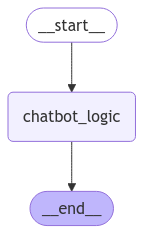

In [21]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
from graphviz import Digraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Define medical keywords and filtering function
MEDICAL_KEYWORDS = [
    "medicine", "symptoms", "diagnosis", "treatment", "disease", "doctor",
    "hospital", "health", "surgery", "therapy", "infection", "pharmacy", "drug"
]

def is_medical_prompt(prompt):
    """Check if the prompt contains medical-related keywords."""
    return any(keyword.lower() in prompt.lower() for keyword in MEDICAL_KEYWORDS)

# Step 8: Initialize workflow visualization with Graphviz
workflow_graph = Digraph("Chatbot Workflow", format="png")
workflow_graph.attr(rankdir="LR")
workflow_graph.node("Start", shape="ellipse", style="filled", color="lightblue")
workflow_graph.node("Filter Prompt", shape="box", style="filled", color="lightgreen")
workflow_graph.node("Generate Response", shape="box", style="filled", color="lightyellow")
workflow_graph.node("Save to DB", shape="box", style="filled", color="orange")
workflow_graph.node("End", shape="ellipse", style="filled", color="lightblue")
workflow_graph.edges([("Start", "Filter Prompt"), ("Filter Prompt", "Generate Response"),
                      ("Generate Response", "Save to DB"), ("Save to DB", "End")])

def render_workflow():
    """Render and display the workflow graph."""
    workflow_graph.render("chatbot_workflow", view=True)

# Step 9: Chatbot logic with state graph integration
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot_logic(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot_logic", chatbot_logic)
graph_builder.add_edge(START, "chatbot_logic")
graph_builder.add_edge("chatbot_logic", END)
graph = graph_builder.compile()

# Step 10: Chatbot Execution Function
def chatbot():
    print("Welcome to the Medical Chatbot! I only answer medical-related questions.\n")
    print("Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            render_workflow()
            try:
                display(Image(graph.get_graph().draw_mermaid_png()))
            except Exception:
                print("Graph rendering failed.")
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            workflow_graph.node(user_input, shape="ellipse", style="dashed", color="grey")
            workflow_graph.edge("Start", user_input)

            if is_medical_prompt(user_input):
                workflow_graph.edge(user_input, "Filter Prompt")
                response = agent.run(user_input)
                workflow_graph.edge("Filter Prompt", "Generate Response")
                print(f"Bot: {response}")
                save_to_db(user_input, response)
                workflow_graph.edge("Generate Response", "Save to DB")
            else:
                print("I'm sorry, I can only assist with medical-related questions.")
                workflow_graph.edge(user_input, "Filter Prompt")
                workflow_graph.edge("Filter Prompt", "End")

# Step 11: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()
